# Predicting Breast Cancer Diagnosis Best Models

This dataset is from the UCI Machine Learning Repository, downloaded from Kaggle. Link [here](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Ten real-valued features are computed for each cell nucleus:

a) **radius** (mean of distances from center to points on the perimeter)<br>
b) **texture** (standard deviation of gray-scale values)<br>
c) **perimeter**<br>
d) **area**<br>
e) **smoothness** (local variation in radius lengths)<br>
f) **compactness** (perimeter^2 / area - 1.0)<br>
g) **concavity** (severity of concave portions of the contour)<br>
h) **concave points** (number of concave portions of the contour)<br>
i) **symmetry**<br>
j) **fractal dimension** ("coastline approximation" - 1)<br>

The columns names ending with "se" or "worst" refer to the standard error or the maximum of that feature observed, respectively.

The target column is the binary "diagnosis" column.

# Summary after 10-fold cross-validation

#### [LogisticRegression](LogisticRegression_Breast_Cancer.ipynb) 
    * Unscaled
        Test accuracy: 0.9287
        Recall: 0.875
        AUPRC: 0.9166
    * Scaled
        Test accuracy: 0.9636
        Recall: 0.925
        AUPRC: 0.9466
    * Unscaled after dropping low-importance columns:
        Test accuracy: 0.9287
        Recall: 0.9
        AUPRC: 0.9166
    * Scaled after dropping low_importance columns:
        Test accuracy: 0.9553
        Recall: 0.95
        AUPRC: 0.9395
        
#### [RandomForestClassifier](RandomForest_Breast_Cancer.ipynb)
    * Unscaled
        Test accuracy:  0.9295
        Recall: 0.875
        AUPRC: 0.9395
    * Scaled
        Test accuracy:  0.9295
        Recall: 0.875
        AUPRC: 0.9395
    * Unscaled after dropping low-importance columns:
        Test accuracy:  0.9295
        Recall: 0.875
        AUPRC: 0.9395
    * Scaled after dropping low_importance columns:
        Test accuracy:  0.9295
        Recall: 0.875
        AUPRC: 0.9395
        
#### [KNN](KNN_Breast_Cancer.ipynb)
    * Unscaled
        Test accuracy: 0.9295
        Recall: 0.835
        AUPRC: 0.8715
    * Scaled
        Test accuracy:  0.9469
        Recall: 0.875
        AUPRC: 0.9095
        
#### [SVC](SVC_Breast_Cancer.ipynb)
    * Unscaled
        Test accuracy:  0.9287
        Recall: 0.9
        AUPRC: 0.9016
    * Scaled
        Test accuracy:  0.9469
        Recall: 0.9
        AUPRC: 0.9617
    * Unscaled after dropping low-importance columns:
        Test accuracy: 0.9287
        Recall: 0.9
        AUPRC: 0.9016
        
#### [XGBClassifier](XGB_Breast_Cancer.ipynb)
    * Unscaled
        Test accuracy: 0.9386
        Recall: 0.9
        AUPRC: 0.9699
    * Scaled
        Test accuracy: 0.9386
        Recall: 0.9
        AUPRC: 0.4373
    * Unscaled after dropping low-importance columns:
        Test accuracy: 0.5699
        Recall: 0.3361
        AUPRC: 0.3595
    * Scaled after dropping low_importance columns:
        Test accuracy: 0.5699
        Recall: 0.3361
        AUPRC: 0.3595

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, recall_score, make_scorer, average_precision_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
cancer = pd.read_csv('breast_cancer.csv')

In [3]:
# An empty list to add F1 scores later for visualizations
f1 = []

# Data Exploration and Model Preparation

In [4]:
cancer.shape

(569, 33)

In [5]:
cancer.head(2)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN


In [6]:
cancer['Unnamed: 32'].isna().mean()

1.0

The column "Unnamed: 32" contains nothing but NaNs, so I will drop that column along with the id column.

In [7]:
cancer = cancer.drop(['Unnamed: 32', 'id'], axis = 1)

Secondly, the "diagnosis" column (the target) needs to be converted from strings to numbers.

In [8]:
diag_map = {'B':0, 'M': 1}

cancer['diagnosis'] = cancer['diagnosis'].map(diag_map)

In [9]:
cancer['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

There is not a large class imbalace, but even so, I will stratify the test set by diagnosis to minimize any imbalace.

In [10]:
X = cancer.drop('diagnosis', 1)
y = cancer['diagnosis']

I will perform a train_test_split to isolate a testing set and a training set.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [12]:
y_train.value_counts()

0    285
1    170
Name: diagnosis, dtype: int64

In [13]:
y_test.value_counts()

0    72
1    42
Name: diagnosis, dtype: int64

I will scale the data and try all models with scaled and un-scaled data.

In [14]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

For each model type, I will perform a GridSearchCV to find the best hyperparameters. Then, using these best hyperparameters, I will build the specified model and obtain the training score, test score, confustion matrix, and a classification report. If the model is able to provide feature importance, I will drop the low-importance features (threshold = 0.1) and run the scaled and unscaled models once more.

To ensure the model is robust, I will perform a 10-fold cross-validation for each model.

I am not only interested in the highest test accuracy, but also the highest recall because this minimizes the number of false negatives. I do not want to tell someone they are healthy when they actually have a malignant breast mass. That person should be receiving care, but instead they would be overlooked. Because of this I will also look at the area under the precision-recall curve (AUPRC).

**This notebook only shows the best model from each category. The full investigations of each model can be found in the notebooks linked in the summary.**

# LogisticRegression

## Scaled

In [15]:
%%time
model_lr_scale = LogisticRegression(C= 20, solver = 'newton-cg', max_iter = 100)
model_lr_scale.fit(X_train_scaled, y_train)

y_pred_lr_s = model_lr_scale.predict(X_test_scaled)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_lr_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)


print('Training Score: {}'.format(model_lr_scale.score(X_train_scaled, y_train)))
print('Test Score: {}'.format(model_lr_scale.score(X_test_scaled, y_test)))
print(classification_report(y_test, y_pred_lr_s))
print(confusion_df)

Training Score: 0.989010989010989
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              71               1
Actually Mal.               2              40
Wall time: 87 ms


In [16]:
cv_scores = cross_val_score(model_lr_scale, X_test_scaled, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_lr_scale, X_test_scaled, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_lr_s)))

Mean cross val accuracy: 0.9636363636363635
Mean cross val recall: 0.925
Area under precision-recall curve:0.9466960083134666


In [17]:
f1.append(f1_score(y_test, y_pred_lr_s))

# RandomForestClassifier

## Scaled, dropped low-importance features

In [18]:
cancer_dropped_s = cancer.drop(columns=['concave points_se'
                                        ,'fractal_dimension_worst'
                                        ,'smoothness_mean'
                                        ,'texture_se'
                                        ,'fractal_dimension_se'
                                        ,'symmetry_se'
                                        ,'compactness_se'
                                        ,'symmetry_mean'
                                        ,'fractal_dimension_mean'
                                        ,'smoothness_se'
                                        ,'concavity_se'
                                        ,'symmetry_worst'])

X = cancer_dropped_s.drop(columns = 'diagnosis')

y = cancer_dropped_s['diagnosis']

X_train_op, X_test_op, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [19]:
scaler = StandardScaler()
scaler.fit(X_train_op)

X_train_scaled_op = scaler.transform(X_train_op)
X_test_scaled_op = scaler.transform(X_test_op)

In [20]:
%%time
model_rfc_scale_op = RandomForestClassifier(criterion = 'entropy', 
                                            max_depth = 20, 
                                            n_estimators = 50,
                                            min_samples_leaf = 5,
                                           random_state = 20)
model_rfc_scale_op.fit(X_train_scaled_op, y_train)

y_pred_rfc_s = model_rfc_scale_op.predict(X_test_scaled_op)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_rfc_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_rfc_scale_op.score(X_train_scaled_op, y_train)))
print('Test Score: {}'.format(model_rfc_scale_op.score(X_test_scaled_op, y_test)))
print(classification_report(y_test, y_pred_rfc_s))
print(confusion_df)

Training Score: 0.9868131868131869
Test Score: 0.9736842105263158
              precision    recall  f1-score   support

           0       0.99      0.97      0.98        72
           1       0.95      0.98      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               1              41
Wall time: 168 ms


In [21]:
cv_scores = cross_val_score(model_rfc_scale_op, X_test_scaled_op, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_rfc_scale_op, X_test_scaled_op, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_rfc_s)))

Mean cross val accuracy: 0.9287878787878787
Mean cross val recall: 0.875
Area under precision-recall curve:0.9395581978201317


In [22]:
f1.append(f1_score(y_test, y_pred_rfc_s))

# KNearestNeighbors

## Scaled

In [23]:
%%time
model_knn_scale = KNeighborsClassifier(weights = 'distance', n_neighbors = 10)
model_knn_scale.fit(X_train_scaled, y_train)

y_pred_knn_s = model_knn_scale.predict(X_test_scaled)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_knn_s),
    index=["Actually 0", "Actually 1",],
    columns=["Predicted 0", "Predicted 1",],
)

print('Training Score: {}'.format(model_knn_scale.score(X_train_scaled, y_train)))
print('Test Score: {}'.format(model_knn_scale.score(X_test_scaled, y_test)))
print(classification_report(y_test, y_pred_knn_s))
print(confusion_df)

Training Score: 1.0
Test Score: 0.956140350877193
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

            Predicted 0  Predicted 1
Actually 0           70            2
Actually 1            3           39
Wall time: 47 ms


In [24]:
cv_scores = cross_val_score(model_knn_scale, X_test_scaled, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_knn_scale, X_test_scaled, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_knn_s)))

Mean cross val accuracy: 0.9469696969696969
Mean cross val recall: 0.875
Area under precision-recall curve:0.909591050797726


In [25]:
f1.append(f1_score(y_test, y_pred_knn_s))

# Support Vector Classifier

## Scaled

In [26]:
%%time
model_svc_scale = SVC(kernel = 'rbf', C = 1)
model_svc_scale.fit(X_train_scaled, y_train)

y_pred_svc_s = model_svc_scale.predict(X_test_scaled)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_svc_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_svc_scale.score(X_train_scaled, y_train)))
print('Test Score: {}'.format(model_svc_scale.score(X_test_scaled, y_test)))
print(classification_report(y_test, y_pred_svc_s))
print(confusion_df)

Training Score: 0.989010989010989
Test Score: 0.9824561403508771
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              71               1
Actually Mal.               1              41
Wall time: 16 ms


In [27]:
cv_scores = cross_val_score(model_svc_scale, X_test_scaled, y_test, cv= 10)
print('Cross val test accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_svc_scale, X_test_scaled, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_svc_s)))

Cross val test accuracy: 0.9469696969696969
Mean cross val recall: 0.9
Area under precision-recall curve:0.96171977562955


In [28]:
f1.append(f1_score(y_test, y_pred_svc_s))

# XGBClassifier

## Unscaled

In [29]:
%%time
model_xgb = XGBClassifier(learning_rate = 0.5, 
                          max_depth = 3, 
                          n_estimators = 100,
                         subsample = 0.9)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_xgb),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)


print('Training Score: {}'.format(model_xgb.score(X_train, y_train)))
print('Test Score: {}'.format(model_xgb.score(X_test, y_test)))

print(classification_report(y_test, y_pred_xgb))
print(confusion_df)

Training Score: 1.0
Test Score: 0.9824561403508771
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              72               0
Actually Mal.               2              40
Wall time: 87.9 ms


In [30]:
cv_scores = cross_val_score(model_xgb, X_test, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_xgb, X_test, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_xgb)))

Mean cross val accuracy: 0.9386363636363635
Mean cross val recall: 0.9
Area under precision-recall curve:0.9699248120300752


In [31]:
f1.append(f1_score(y_test, y_pred_xgb))

In [32]:
f1_df = pd.DataFrame(data = {'Model': ['LR', 'RF', 'KNN', 'SVC', 'XGB'], 'F1 Score': f1})

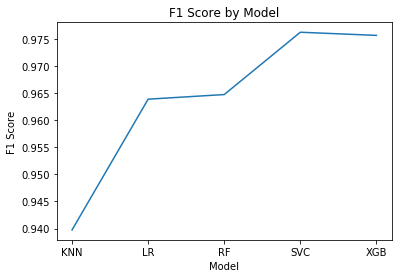

In [33]:
sns.lineplot(data=f1_df, x = 'Model', y = 'F1 Score')
plt.title('F1 Score by Model')
plt.show()